In [71]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil


# NOTE: change to your own path when setting workspace
ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


### Step 1: Get Microsoft Building Footprint Data

The data needs to be broken into a subset, even smaller than the United States--no need for 129 million buildings in a massive geojson. Instead, we have to parse the quadkeys (an indexing technique used in vector tiling) into lat/long. For this, we will use the `mercantile` package.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Mercantile Documentation](https://mercantile.readthedocs.io/_/downloads/en/latest/pdf/)

In [65]:
# get state bounds
state = 'arizona'
state_df = gpd.read_file(f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson')
state_geo = gpd.GeoDataFrame(state_df, crs=4326)

In [72]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(ws + filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

with ZipFile(f, 'r') as z:
    z.extractall(
        path=filename
        )
    
buildings_df = gpd.read_file(filename)

ValueError: seek of closed file

In [63]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))

mean_df['geometry'] = Point([mean_df['latitude'], mean_df['longitude']])


AttributeError: 'DataArray' object has no attribute 'reshape'

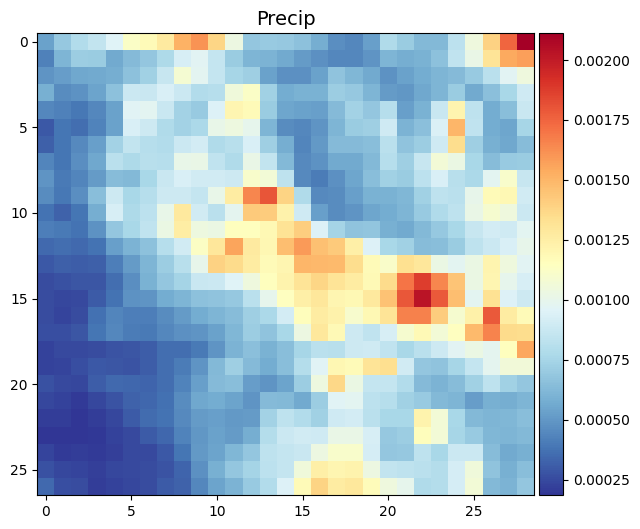

In [28]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean_precip.to_array()[0], cmap='RdYlBu_r')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [37]:
tp.iloc[0]

tp    0.000332
Name: (2013-01-01 00:00:00, 1, 37.5, -115.0), dtype: float32